### Legal Text Clustering.

In this notebook we are going to perform Legal document clustering using the dataset that we are going to use was found on [kaggle](https://www.kaggle.com/datasets/amohankumar/legal-text-classification-dataset).

> https://www.kaggle.com/datasets/amohankumar/legal-text-classification-dataset



### Installing Helper Packages

In the following code cell we are going to install the package called ``helperfns`` that provide us with some usefull helper functions for machine learning.

In [1]:
!pip install helperfns kaggle pigmenta -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 25.2 MB/s eta 0:00:00


### Imports

In the following code cell we are going to import all the packages that we are going to use throughout this notebook

In [43]:
import torch
import random
import warnings
import seaborn as sns
import os
import json
import re

from collections import Counter, defaultdict
from helperfns.tables import tabulate_data
from pigmenta import PALETTES
from helperfns.visualization import plot_wordcloud
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mutual_info_score, adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from torch import nn
from sklearn.utils import resample
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F

warnings.filterwarnings('ignore')

print("torch: ", torch.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

torch:  2.6.0+cu124
numpy:  2.0.2
pandas:  2.2.2


### Setting seeds


In the following code cell we are going to set the seed to all random operations for reproducivity.

In [2]:
SEED = 23
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device
In the following code cell we are going to get ``gpu`` device if possible

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data
We are going to download the data from `kaggle` at this url: https://www.kaggle.com/datasets/amohankumar/legal-text-classification-dataset

In [5]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']

In [6]:
!kaggle datasets download amohankumar/legal-text-classification-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/amohankumar/legal-text-classification-dataset
License(s): apache-2.0
  0% 0.00/14.9M [00:00<?, ?B/s]
100% 14.9M/14.9M [00:00<00:00, 1.22GB/s]


### Word Embeddings

In the following code cell we are going to download word embeddings from kaggle:

url: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation

In [7]:
!kaggle datasets download rtatman/glove-global-vectors-for-word-representation --unzip # glove vectors

Dataset URL: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation
License(s): other
 95% 434M/458M [00:01<00:00, 309MB/s]
100% 458M/458M [00:01<00:00, 380MB/s]


Next we are going to read our data from text files into pandas dataframe using the `read_csv` method.

In [8]:
dataframe = pd.read_csv('legal_text_classification.csv')
dataframe.head(2)

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...


In the next code cell we are then going to remove null values from the dataframe.

In [9]:
if sum(dataframe.isna().any()):
  dataframe.dropna(inplace=True)
  dataframe.reset_index(drop=True, inplace=True)
dataframe.isna().any()

,0
case_id,False
case_outcome,False
case_title,False
case_text,False


In the next code cell we are then going to drop the columns that we are not intrested in.

In [10]:
dataframe.drop(columns=["case_id", "case_title"], inplace=True)
dataframe.head(2)

,case_outcome,case_text
0,cited,Ordinarily that discretion will be exercised s...
1,cited,The general principles governing the exercise ...


Next we are going to check the distribution of labels in the dataset.

In [11]:
dataframe.case_outcome.value_counts()

,count
case_outcome,
cited,12110
referred to,4363
applied,2438
followed,2252
considered,1699
discussed,1018
distinguished,603
related,112
approved,108


Next we are only going to select `['cited', 'referred to', "applied", 'followed']` the case text that has the following labels from the dataset.

In [12]:
dataframe = dataframe[dataframe['case_outcome'].isin(['cited', 'referred to', "applied", 'followed'])]
dataframe.case_outcome.value_counts()

,count
case_outcome,
cited,12110
referred to,4363
applied,2438
followed,2252


In the next code cell we are then going to balance the dataset based on the class that has minority labels in the entire dataset.

In [13]:
new_dataframe = dataframe.copy()

min_class_count = new_dataframe['case_outcome'].value_counts().min()
downsampled_list = []
for label in new_dataframe['case_outcome'].unique():
    class_df = new_dataframe[new_dataframe['case_outcome'] == label]
    downsampled_class_df = resample(
        class_df,
        replace=False,
        n_samples=min_class_count,
        random_state=SEED
    )
    downsampled_list.append(downsampled_class_df)
balanced_df = pd.concat(downsampled_list).reset_index(drop=True)

In the following code cell we are then going to visualize the distribution of labels after the dataset was balanced.

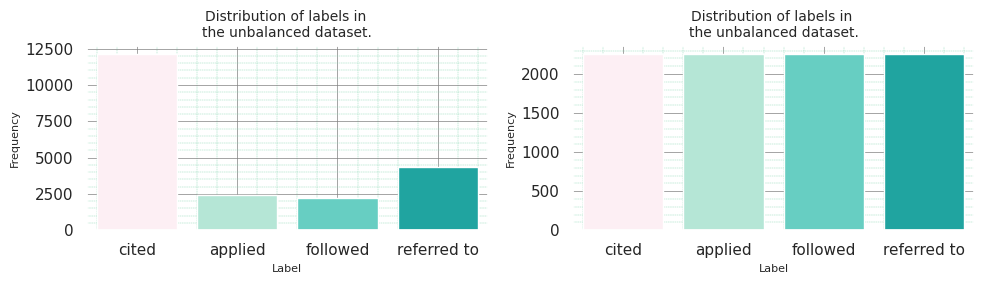

In [17]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=False)
axes = axes.flatten()
sns.countplot(data=dataframe, x="case_outcome", palette=PALETTES.gradient[:4],
              legend=False,  ax=axes[0], fill=True)
axes[0].set_xlabel("Label", fontsize=8)
axes[0].set_ylabel("Frequency", fontsize=8)
axes[0].set_title(f"Distribution of labels in \nthe unbalanced dataset.", fontsize=10)
axes[0].minorticks_on()
axes[0].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[0].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

sns.countplot(data=balanced_df, x="case_outcome", palette=PALETTES.gradient[:4],
              legend=False,  ax=axes[1], fill=True)
axes[1].set_xlabel("Label", fontsize=8)
axes[1].set_ylabel("Frequency", fontsize=8)
axes[1].set_title(f"Distribution of labels in \nthe unbalanced dataset.", fontsize=10)
axes[1].minorticks_on()
axes[1].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[1].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

In the following code cell we are then going to extract the case text and then clean them.

In [18]:
texts = balanced_df.case_text.values
random.shuffle(texts)

def clean_sentence(sent: str, lower: bool = True) -> str:
    sent = sent.lower() if lower else sent
    sent = re.sub(
        r"(@|#)([A-Za-z0-9]+)", " ", sent
    )
    sent = re.sub(
        r"([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+", " ", sent
    )
    sent = re.sub(r"https?\S+", " ", sent, flags=re.MULTILINE)  # removing url's
    sent = re.sub(r"\d", " ", sent)  # removing none word characters
    sent = re.sub(
        r"[^\w\s\']", " ", sent
    )
    sent = re.sub(r"\s+", " ", sent).strip()  # remove more than one space
    return  sent
texts = [clean_sentence(i) for i in texts]

Next we are goint to create a counter object that will contain word counts that we are going to use to create our own vocabulary later on.

In [19]:
counter = Counter()
for line in texts:
    counter.update(line.lower().split())

Next we are going to visualize the most common words in the dataset after it was cleaned using word clouds.

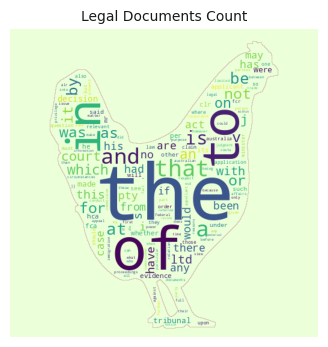

In [22]:
plot_wordcloud(
    counter, title="Most Common Words in the dataset", mask="chicken", background_color=PALETTES.sky[0], figsize=(4, 4),
    fontsize=10
)

### Vocabulary
Next we are going to create a vocabulary class and initialize it based on the `counter` object. We are going to specify the ``min_freq`` to ``2`` meaning that the words that does not appear at least ``2`` times will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object.

In [23]:
class vocab:
    def __init__(self, counter, min_freq=1, specials=('[unk]', '[pad]', '[sos]', '[eos]')):
        self.freqs = counter
        self.itos = list(specials)
        self.stoi = {}
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.itos:
                self.itos.append(token)

        self.stoi = defaultdict(lambda: self.itos.index('[unk]'))  # default to unk
        for idx, token in enumerate(self.itos):
            self.stoi[token] = idx

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        return self.stoi[token]

    def get_stoi(self):
        return self.stoi
    def get_itos(self):
        return self.itos


vocabulary = vocab(counter, min_freq=2, specials=('[unk]', '[pad]', '[sos]', '[eos]'))

### STOI - ``String To Integer``
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called stoi which is essentially a dictionary of word to index mapping. This dictionary will be used during training as well as during model inference.

In [24]:
stoi = vocabulary.get_stoi()

### Text Pipeline
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the ``text_pipeline`` function comes into play. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay (``stoi``) will be converted to an unkown (``'[unk]'``) token (0).

In [25]:
def text_pipeline(x: str):
  values = list()
  tokens = x.lower().split(" ") # convert to lower case.
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['[unk]']
    values.append(v)
  return values

### Pretrained vectors
In the following code cell we are going to download the predtrained word vectors. We are going to use the ``GloVe.6B.100d``. These are pretrained vectors that were trained with about ``~6B`` words and have a vector representation of a word in ``100`` dimension for each word.

In [27]:
embedding_path = "glove.6B.100d.txt"
EMBEDDING_DIM = 100
glove_vectors = dict()
with open(embedding_path, encoding="utf8") as glove:
  for line in glove:
    records = line.split();
    word = records[0]
    vectors = np.asarray(records[1: ], dtype=np.float32)
    glove_vectors[word] = vectors

### Creating Embedding matrix
Now that we have our glove vectors we need to costomize them so that they fit our use case. We are going to create an embedding matrix that suits the our vocabulary. So essentially this embedding matrix will be the word to vector mapping for all the words that arein our vocabulary.

In [28]:
VOCAB_SIZE = len(stoi)
EMBEDDING_MATRIX= torch.zeros([VOCAB_SIZE, EMBEDDING_DIM])
for word, index in stoi.items():
  vector = glove_vectors.get(word)
  if vector is not None:
    try:
      EMBEDDING_MATRIX[index] = torch.from_numpy(vector)
    except IndexError or Exception:
      pass


In the followig code cell we are going to check the embedding matrix for the word ``"people"``.

In [29]:
EMBEDDING_MATRIX[stoi['people']]

tensor([ 0.2902,  0.8050,  0.3119, -0.3271, -0.4724,  1.1363, -0.3797,  0.1157,
         0.4191,  0.0163, -0.0654, -0.0040,  0.7769, -0.2494,  0.1882, -0.6401,
        -0.0203, -0.1853, -1.0651,  0.6912,  1.0472,  0.3617,  0.8086, -0.4277,
        -0.1830, -0.2785,  0.4384, -0.0233,  0.3736, -0.3588,  0.4726,  0.7395,
         0.0151,  0.0599, -0.0668, -0.3884,  0.2236,  0.8057,  0.3379, -0.0522,
        -1.1057, -0.1113,  0.1510, -0.6665, -0.0450, -0.0682,  0.0990, -0.5594,
        -0.7811, -0.5095, -0.3733, -0.7567,  0.2258,  1.2963, -0.4818, -1.8180,
         0.3853, -0.2185,  2.2418,  0.2009, -0.3521,  1.4893, -0.2170, -0.2462,
         0.5519,  0.9722,  0.5853, -0.0298,  0.5794, -0.6480, -0.1237, -0.5346,
        -0.2053, -0.5360,  0.3090,  0.5393,  0.1185,  0.4275, -1.0872, -0.2341,
         0.7388,  0.1575, -0.5664,  0.1623, -1.9117, -0.0193, -0.5029, -0.1758,
        -0.5388, -0.3940,  0.8133, -0.3165,  0.2597, -0.4820, -1.4452,  0.2742,
        -0.7265, -0.3360,  0.4600, -0.11

### Creating Dataset for Training
In the following code cell we are going to create a dataset class called `LegalCitationDataset`. This dataset will takes in the labels and the text of a set.

In [30]:
class LegalCitationDataset(torch.utils.data.Dataset):
  def __init__(self, text):
    super(LegalCitationDataset, self).__init__()
    self.text = text

  def __getitem__(self, index):
    return self.text[index]

  def __len__(self):
    return len(self.text)

### ``collate_fn``
We are going to create a collate function called ``tokenize_batch``. This function actually takes in a batch and does the preprocessing of the ``text`` . This function will be passed to the ``DataLoader`` class to do the preprocessing of ``features``.

### ``tokenize_batch`` function:

* this function takes in a batch in each set and convert the features to integer representation.
* It goes ahead and ``pad`` and ``truncate`` the sequence to the same length and returns ``features``.

In [31]:
def tokenize_batch(batch, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_list = []
  for _text in batch:
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text.lower()), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  return torch.cat(text_list, dim=0)

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `LegalCitationDataset` class.

In [32]:
dataset = LegalCitationDataset(texts)

### Iterators
In the following code cell we are going to create loaders using the ``DataLoader`` class from ``torch.utils.data``.

In [33]:
BATCH_SIZE = 1012
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)

Checking a single Batch Data

In [34]:
txt = next(iter(loader))

The first sentence in the batch.

In [35]:
txt[0]

tensor([  349,   654,    38,   131,    40,    27,   131,   407,    37,     6,
         4823,   100,    82,  2067,    37,  2033,  2035,    93,    27,  1724,
           30,  1016,   682,   184,    15,  1204,  5927,    38,    13,  3482,
         2041,    27,   362,  1460,     6,   928,    37, 18051,  2054,  2256,
         7287,    27, 18051,   437,  2054,  2256,  7287,    27,   358,  2651,
          184,  1245,   301,  5156,   111,  3221,  2356,     6,   882,    37,
         2033,  2035,    27,    30,  1016,   682,   301,   381,  3620,  2088,
         2033,  2035,  4574,    30,    15,  1204,     9,     6,  1204,    37,
         5940,    37,     6, 11014,  2869,   100,   589,     6,  4730,   100,
          175,   135,     6,  4730,   100,  1781,  2046,  2041,   655,    15],
       dtype=torch.int32)

### TextEncoderGRU

In the following code cell we are going to build a model using `GRU` layers which will convert the texts into a lower dimension that we can use for clustering.

In [36]:
class TextEncoderGRU(nn.Module):
  def __init__(self, vocab_size, embedding_size,
               hidden_size, output_size, num_layers,
               bidirectional, dropout, pad_index
               ):
    super(TextEncoderGRU, self).__init__()
    self.embedding = nn.Sequential(
          nn.Embedding(
              vocab_size, embedding_size, padding_idx=pad_index
        )
    )

    self.gru = nn.Sequential(
          nn.GRU(
              embedding_size, hidden_size = hidden_size,
              bidirectional=bidirectional,
              num_layers=num_layers,
              dropout = dropout,
              batch_first=True,
          )
    )
    self.out = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=output_size)
    )

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, batch_first=True, enforce_sorted=False
    )
    packed_output, hidden = self.gru(packed_embedded)
    if self.gru[0].bidirectional:
      hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
    else:
      hidden = hidden[-1]
    return self.out(hidden)

Next we are going to create an instance of a `TextEncoderGRU`.

In [37]:
INPUT_DIM = VOCAB_SIZE
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 4
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = stoi['[pad]']
bigru_txt_encoder = TextEncoderGRU(
              INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              PAD_IDX
).to(device)
bigru_txt_encoder

TextEncoderGRU(
  (embedding): Sequential(
    (0): Embedding(25627, 100, padding_idx=1)
  )
  (gru): Sequential(
    (0): GRU(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=4, bias=True)
  )
)

### Model Parameters

In the following code cell we are going to count parameters for our `TextEncoderGRU` model.

In [38]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["BiGRU", *count_trainable_params(bigru_txt_encoder)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+-------+--------------+------------------+
| MODEL | TOTAL PARAMS | TRAINABLE PARAMS |
+-------+--------------+------------------+
| BiGRU |    4,297,360 |        4,297,360 |
+-------+--------------+------------------+


### Loading Embedding Vectors
In the following code cells we are going to load the pretained custom vectors in our embedding layer to our model. We are going to load the embedding vectors tha suits our data using the ``model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)``

In [39]:
assert EMBEDDING_MATRIX.size(0) == VOCAB_SIZE, "This should match!"

In [40]:
bigru_txt_encoder.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1688, -0.0718, -0.0711,  ...,  0.7898,  0.4515, -0.3860],
        [-0.1365, -0.0666, -0.0902,  ...,  0.3884, -0.0017,  0.1662]],
       device='cuda:0')

Next we are going to extract the features using the `TextEncoderGRU` from the texts and put them in a numpy array.

In [41]:
features = []
with torch.no_grad():
  for X in loader:

    bigru_txt_encoder.eval()
    X = X.to(device)
    lengths = torch.tensor([len(i) for i in X])
    features.append(bigru_txt_encoder(X, lengths).detach().cpu().numpy())
features = np.concatenate(features, axis=0)
features.shape

(9008, 4)

In the next code cell we are going to use the `SpectralClustering` to cluster the legal doccuments into `3` different clusters.

In [42]:
N_CLUSTERS = 3
spectral = SpectralClustering(n_clusters=N_CLUSTERS, affinity='nearest_neighbors',
                              assign_labels='kmeans', random_state=SEED)
spectral_labels = spectral.fit_predict(features)

In the following code cell we are then going to evaluate the `SpectralClustering` on these text doccuments using different clustering metrics.

In [46]:

def evaluate_algorithms(algorithm, X, predicted_labels, true_labels=None):
  metrics = {
    "Silhouette Score": float(silhouette_score(X, predicted_labels)),
    "Davies-Bouldin Index": float(davies_bouldin_score(X, predicted_labels)),
    "Calinski-Harabasz Index": float(calinski_harabasz_score(X, predicted_labels))
  }
  if true_labels is not None:
    metrics["Mutual Info Score"] = mutual_info_score(true_labels, predicted_labels)
    metrics["Adjusted Rand Score"] = adjusted_rand_score(true_labels, predicted_labels)
  return metrics

metrics = evaluate_algorithms(spectral, features, spectral_labels)
metrics

{'Silhouette Score': 0.2290930449962616,
 'Davies-Bouldin Index': 1.4813204406460025,
 'Calinski-Harabasz Index': 2921.817626953125}

In [56]:
tabulate_data(["Metric", "Value"], [(k, f"{v:.3f}") for k, v in metrics.items()], title="Spectral Clustering Metrics")

Spectral Clustering Metrics
+-------------------------+----------+
| Metric                  |    Value |
+-------------------------+----------+
| Silhouette Score        |    0.229 |
| Davies-Bouldin Index    |    1.481 |
| Calinski-Harabasz Index | 2921.818 |
+-------------------------+----------+


Next we are going to use the `TNSE` to do dimensinality reduction on the features before ploting clusters as follows:

In [57]:
X_reduced = TSNE(n_components=2, perplexity=30).fit_transform(features)

In the next code cell we are then going to plot our clusters and see what the model did.

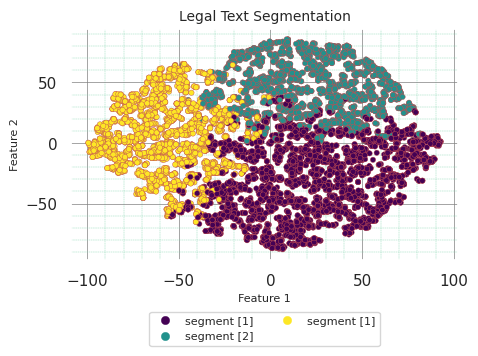

In [58]:
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    X_reduced[:, 0], X_reduced[:, 1], c=spectral_labels, cmap='viridis', s=15,  edgecolor="r", linewidths=0.3
)
plt.title("Legal Text Segmentation", fontsize=10)
plt.xlabel("Feature 1", fontsize=8)
plt.ylabel("Feature 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.legend(
    handles=scatter.legend_elements()[0], labels=[f"segment [{i+1}]" for i in spectral_labels],
    fontsize=8,  loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2
)
plt.minorticks_on()
plt.show()